In [1]:
import numpy as np
import matplotlib 
import matplotlib as mpl

import lightkurve as lk

from gatspy import  periodic

from tqdm import tqdm

import glob, os

from astropy.table import Table
from astropy.io import fits
import fitsio

%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['figure.figsize']=(10.0,10.0)    #(6.0,4.0)
matplotlib.rcParams['font.size']=16              #10 
matplotlib.rcParams['savefig.dpi']= 300             #72 
colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams["font.family"] = "Times New Roman"


Populating the interactive namespace from numpy and matplotlib


In [2]:
data_all = lk.search_lightcurvefile('CR Dra').download_all()


/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/lightkurve-2.0.1.dev0-py3.7.egg/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)


In [3]:
stitched = data_all.stitch()

/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/lightkurve-2.0.1.dev0-py3.7.egg/lightkurve/collections.py:213: LightkurveWarning: Stitching a `LightCurveFileCollection` which contains both SAP and PDCSAP_FLUX. Using PDCSAP_FLUX. You can remove this warning by explicitely using `LightCurveFileCollection.PDCSAP_FLUX.stitch()`.
  LightkurveWarning)


In [4]:
data = lk.search_lightcurvefile('CR Dra').download()
tpf = lk.search_targetpixelfile('CR Dra').download()

/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/lightkurve-2.0.1.dev0-py3.7.egg/lightkurve/search.py:233: LightkurveWarning: Warning: 3 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/lightkurve-2.0.1.dev0-py3.7.egg/lightkurve/lightcurvefile.py:47: LightkurveWarning: `LightCurveFile.header` is deprecated, please use `LightCurveFile.get_header()` instead.
  LightkurveWarning)
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/lightkurve-2.0.1.dev0-py3.7.egg/lightkurve/search.py:233: LightkurveWarning: Warning: 3 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


In [5]:
lc = data.PDCSAP_FLUX.remove_nans().normalize()

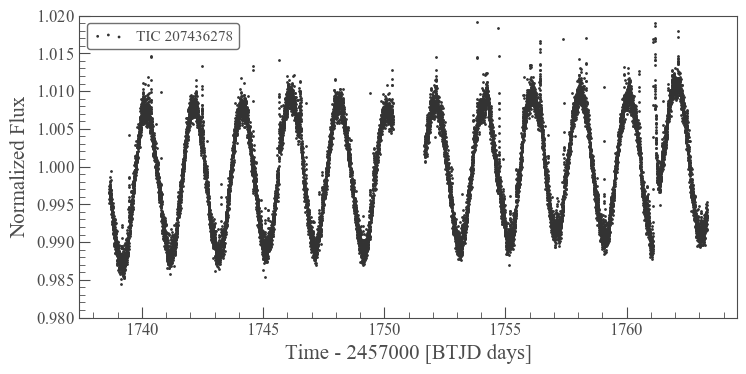

In [6]:
lc.scatter()
plt.ylim(0.98,1.02)
plt.savefig('cr_dra.png')

In [7]:
tpf.interact()

In [8]:
bg = tpf.get_bkg_lightcurve()

(1760, 1762)

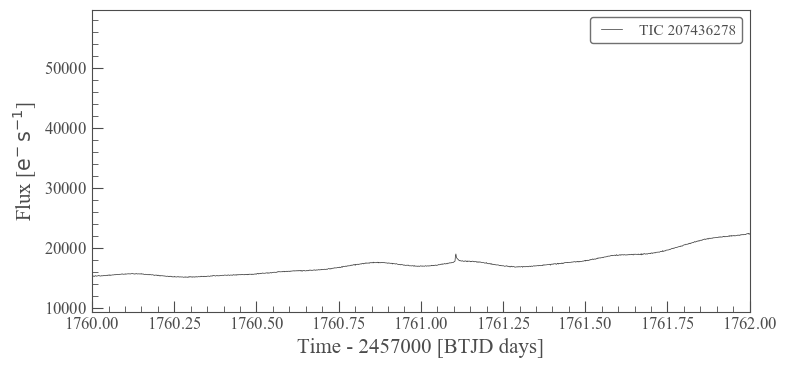

In [9]:
bg.plot()
plt.xlim(1760,1762)

In [10]:
pgram = lc.to_periodogram()

In [11]:
from astropy.timeseries import LombScargle

In [12]:
ls = LombScargle(lc.time,lc.flux,lc.flux_err)

In [13]:
periods = np.linspace(1.,3,20000)
freqs = 1./periods[::-1]

In [14]:
%%time
power = ls.power(freqs)

CPU times: user 13.4 s, sys: 104 ms, total: 13.5 s
Wall time: 13.7 s


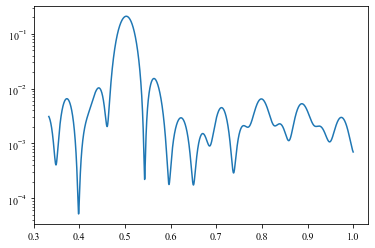

In [15]:
plt.plot(freqs,power)
plt.yscale('log')

In [16]:
1./(freqs[np.argmax(power)])

1.9881494074703736

In [17]:
model = ls.model(lc.time,freqs[np.argmax(power)])

In [18]:
fourier = LombScargle(lc.time,lc.flux,lc.flux_err,nterms=2)

In [19]:
series = fourier.model(lc.time,freqs[np.argmax(power)])

(0.98, 1.02)

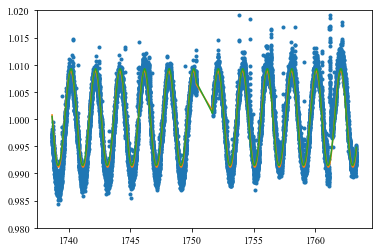

In [20]:

plt.plot(lc.time,lc.flux,'.')
plt.plot(lc.time,model)
plt.plot(lc.time,series)
plt.ylim(0.98,1.02)

(-0.01, 0.01)

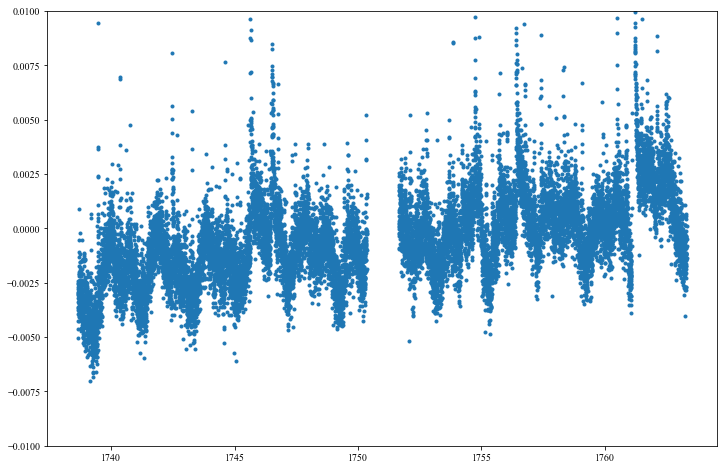

In [21]:
fig = plt.figure(figsize=(12.0,8.0))
plt.plot(lc.time,lc.flux-series,'.')
plt.ylim(-0.01,0.01)

In [22]:
flat, trend = lc.flatten(return_trend=True)

(0.98, 1.02)

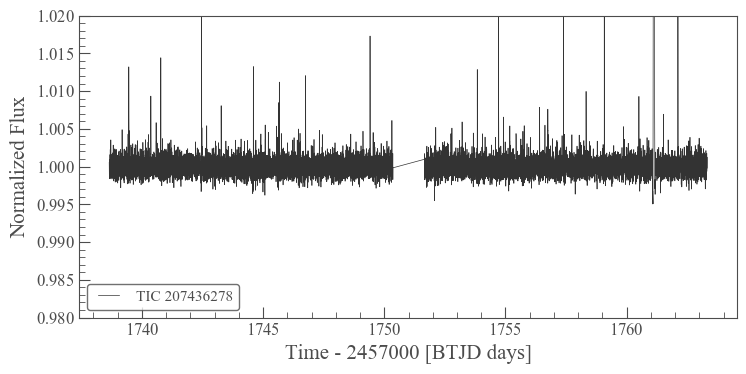

In [23]:
flat.plot()
plt.ylim(0.98,1.02)

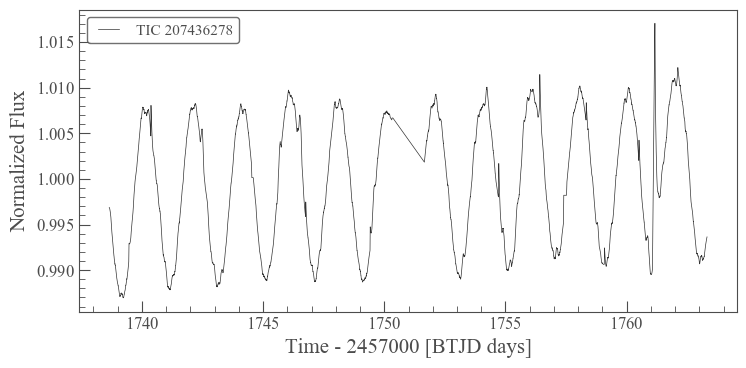

In [24]:
trend.plot()

In [25]:
lc.targetid

207436278

In [26]:
date = lk.utils.btjd_to_astropy_time(lc.time)

In [27]:
start = date.to_datetime()[0]
end = date.to_datetime()[-1]

In [28]:
print(start.date())
print(end.date())

2019-09-12
2019-10-06


In [29]:
lc2 = lc.copy()
lc2.flux = lc.flux - series + np.nanmedian(series)

(0.98, 1.02)

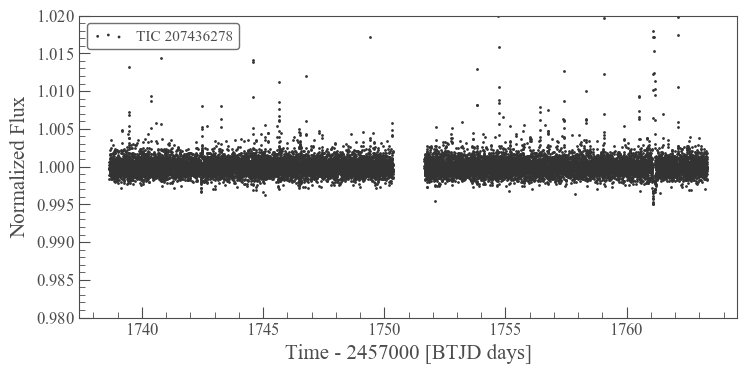

In [30]:
lc2.flatten().scatter()
plt.ylim(0.98,1.02)


In [31]:
cleaned, outliers = lc2.flatten().remove_outliers(return_mask=True)

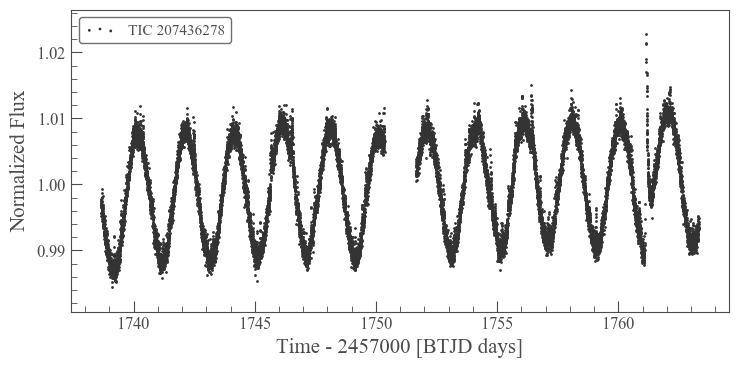

In [32]:
lc[~outliers].scatter()

In [33]:
%%time

tmodel = periodic.TrendedLombScargle(fit_period=True,Nterms=2)
tmodel.quiet = True
tmodel.optimizer.period_range = (1.9, 2.1)

lc_test = lc.copy()
outliers = [0]

for j in tqdm(range(5),desc='Outlier clipping',postfix={'Outliers':np.sum(outliers)}):
    
    tm = tmodel.fit(lc_test.time, lc_test.flux, lc_test.flux_err)
    series = tm.predict(lc_test.time)
    lc2 = lc_test.copy()
    lc2.flux = lc_test.flux - series + np.nanmedian(series)
    cleaned, outliers = lc2.remove_outliers(return_mask=True,sigma=3.0)
    
    lc_test = lc_test[~outliers]
final = tm.predict(lc.time)

Outlier clipping:   0%|          | 0/5 [00:00<?, ?it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.255
 - Using 5 steps per peak; omega_step = 0.0509
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Outlier clipping:  20%|██        | 1/5 [00:00<00:02,  1.64it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.255
 - Using 5 steps per peak; omega_step = 0.0509
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Outlier clipping:  40%|████      | 2/5 [00:01<00:01,  1.69it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.255
 - Using 5 steps per peak; omega_step = 0.0509
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Outlier clipping:  60%|██████    | 3/5 [00:01<00:01,  1.73it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.255
 - Using 5 steps per peak; omega_step = 0.0509
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Outlier clipping:  80%|████████  | 4/5 [00:02<00:00,  1.78it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.255
 - Using 5 steps per peak; omega_step = 0.0509
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Outlier clipping: 100%|██████████| 5/5 [00:02<00:00,  1.83it/s, Outliers=0]

CPU times: user 10.3 s, sys: 191 ms, total: 10.5 s
Wall time: 2.73 s


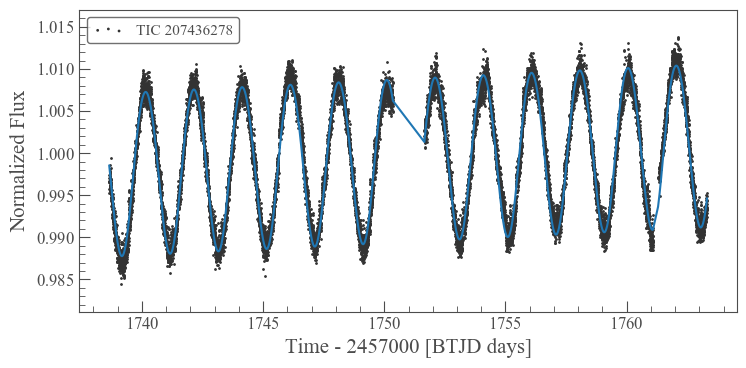

In [34]:
lc_test.scatter()
plt.plot(lc_test.time,series,color=colours[0])

<Figure size 864x432 with 0 Axes>

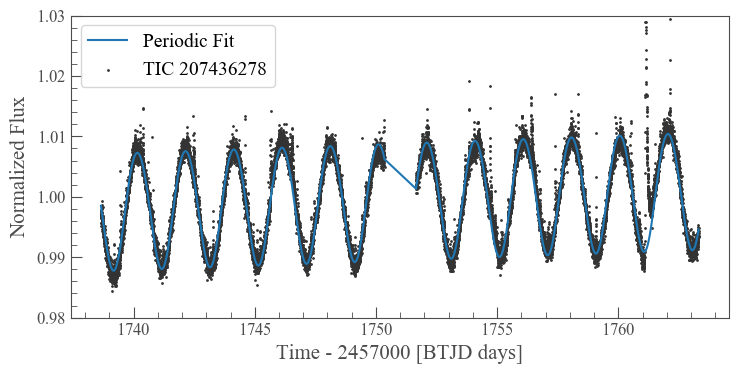

In [35]:
fig = plt.figure(figsize = (12.0,6.0))
lc.scatter()
plt.plot(lc.time,final,color=colours[0],label='Periodic Fit')
plt.legend(frameon=True,fontsize=14)
plt.ylim(0.98,1.03)
plt.savefig('cr_dra_trend.pdf',bbox_inches='tight')
plt.savefig('cr_dra_trend.png',bbox_inches='tight')

(0.98, 1.02)

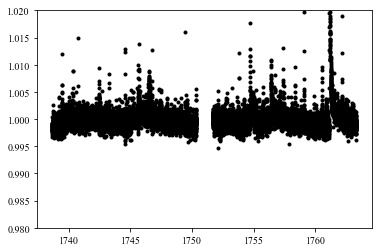

In [36]:
plt.plot(lc.time,lc.flux-final+np.nanmedian(final),'.k')
plt.ylim(0.98,1.02)

In [37]:
lk.corrector.Corrector

lightkurve.correctors.corrector.Corrector

In [38]:
cbvs = fitsio.FITS('../data/tess2019253231442-s0016-3-4-0152-s_cbv.fits')

In [39]:
cbvs


  file: ../data/tess2019253231442-s0016-3-4-0152-s_cbv.fits
  mode: READONLY
  extnum hdutype         hduname[v]
  0      IMAGE_HDU       PRIMARY[1]
  1      BINARY_TBL      CBV.single-scale.3.4[1]
  2      BINARY_TBL      CBV.spike.3.4[1]
  3      BINARY_TBL      CBV.multiscale-band-1.3.4[1]
  4      BINARY_TBL      CBV.multiscale-band-2.3.4[1]
  5      BINARY_TBL      CBV.multiscale-band-3.3.4[1]

In [40]:
dummy = []
cadenceno = cbvs[4]['CADENCENO'][:]
for j in range(8):
    dummy.append(cbvs[4]['VECTOR_%d' % (j+1)][:])
cbvs_mat = np.vstack(dummy)

In [41]:
def match_cadences(cbvcads,lccads):
    indices =np.array([1 if j in lccads else 0 for j in cbvcads])
    return np.where(indices==1)[0]


In [42]:
match = match_cadences(cadenceno,lc_test.cadenceno)

In [43]:
def apply_cbvs(lcc):
    cbvs = fitsio.FITS('../data/tess2019253231442-s0016-3-4-0152-s_cbv.fits')

In [44]:

regressors = cbvs_mat[:,match].T
dm = lk.DesignMatrix(regressors, name='regressors')


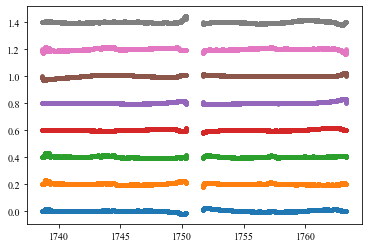

In [45]:
plt.plot(lc_test.time, dm.values + np.arange(8)*0.2, '.');


In [46]:
dm = dm.append_constant()

In [47]:
residuals = lc_test.copy()
residuals.flux = lc_test.flux - series + np.nanmedian(series)
corrector = lk.RegressionCorrector(residuals)

In [48]:
corrected_lc = corrector.correct(dm)


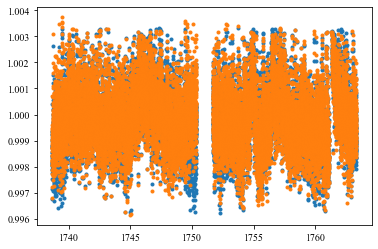

In [49]:
plt.plot(residuals.time,residuals.flux,'.')
plt.plot(corrected_lc.time,corrected_lc.flux,'.')

In [50]:
tm.best_period

1.990524996521418

(0.975, 1.04)

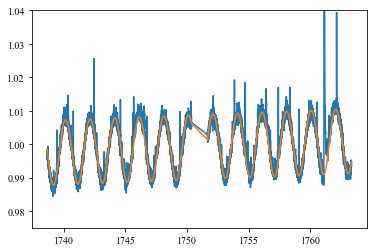

In [51]:
plt.plot(lc.time,lc.flux)
plt.plot(lc.time,final)
plt.ylim(0.975,1.04)

(0.99, 1.02)

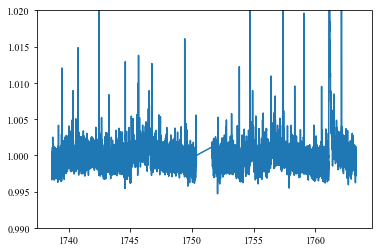

In [52]:
plt.plot(lc.time,lc.flux-final+np.nanmedian(final))
plt.ylim(0.99,1.02)

In [53]:
lc_new = lc.copy()
lc_new.flux -= final - np.nanmedian(final)
lc_newf = lc_new.flatten(return_trend=True,window_length=51,polyorder=2)

In [54]:
lc_clean, flares = (lc_newf[0].remove_outliers(return_mask=True,sigma_lower=10,sigma_upper=3))
flares[lc_new.flux>1.005] = True

In [55]:
for_adina = Table({'time':lc.time,'flux':lc.flux,'trend':final,'flare':flares})
for_adina.write('cr_dra.txt',format='ascii')

### Now let's look at the radio data

In [56]:
!ls

GJ486.ipynb
cr_dra.ipynb
cr_dra.png
cr_dra.txt
cr_dra_flare_zoom_s16.jpg
cr_dra_flare_zoom_s23.jpg
cr_dra_flares_all.jpg
cr_dra_flares_all.pdf
cr_dra_flares_s16.jpg
cr_dra_flares_s23.jpg
cr_dra_flares_s24.jpg
cr_dra_lomb_scargle.pdf
cr_dra_lomb_scargle.png
cr_dra_priorised_I.fits
cr_dra_radio_folded.png
cr_dra_stokes_i_finalisedfluxes.fits
cr_dra_trend.pdf
cr_dra_trend.png
date_obs_crdra.fits
date_obs_crdra_paper.fits
gj_1151.ipynb
gj_1151_tess.png
gj_625.ipynb
joe_detections.ipynb
lofar_read.ipynb
lomb_scargle.png
m_dwarf_dections_27_03_20_correct_fluxes.fits
quicklook
quicklook_tess.tar.gz


In [57]:
radio = Table.read('cr_dra_stokes_i_finalisedfluxes.fits')
dates = Table.read('date_obs_crdra_paper.fits')

In [58]:
from astropy.time import Time

In [59]:
t = Time(dates['date_obs'], format='isot', scale='utc').mjd

In [60]:
flux = radio['int_flux']
error = radio['err_int_flux']

<ErrorbarContainer object of 3 artists>

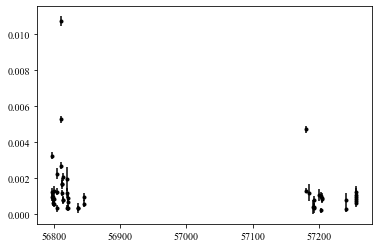

In [61]:
plt.errorbar(t,flux,yerr=error,fmt='.k')
# plt.xlim(56780,56850)

In [62]:
t[flux==flux.max()]

array([56810.81259259])

In [63]:
bad = (flux>0.0015) + (t>56810)*(t<56820)  + (error>0.00085)

<ErrorbarContainer object of 3 artists>

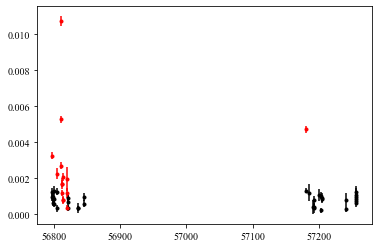

In [64]:
plt.errorbar(t[~bad],flux[~bad],yerr=error[~bad],fmt='.k')
plt.errorbar(t[bad],flux[bad],yerr=error[bad],fmt='.r')
# plt.xlim(56780,56850)
# plt.xlim(56780,56850)

In [65]:
from astropy.timeseries import TimeSeries
import astropy.units as u


In [66]:
ts = TimeSeries(time=Time(dates['date_obs'], format='isot', scale='utc')[~bad],data=radio[~bad])

In [67]:
folded = ts.fold(tm.best_period*u.day,midpoint_epoch = ts['time'][12])

In [68]:
gg = []
for j, epoch in enumerate(ts['time']):
    folded = ts.fold(tm.best_period*u.day,midpoint_epoch = epoch)
    gaps = np.diff(folded['time'])
    gg.append(np.nanstd(gaps))
gg = [g.value for g in gg]

In [69]:
folded = ts.fold(tm.best_period*u.day,midpoint_epoch = ts['time'][19])

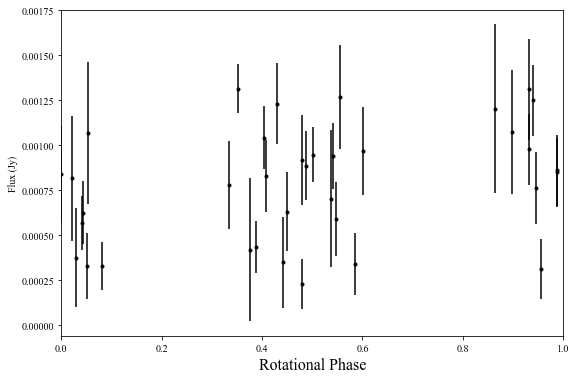

In [70]:
fig = plt.figure(figsize=(9.0,6.0))
plt.errorbar((folded['time'].jd-folded['time'].jd.min())/tm.best_period,folded['int_flux'],yerr=folded['err_int_flux'],fmt='.k')
plt.xlim(0,1)
plt.xlabel('Rotational Phase',fontsize=16)
plt.ylabel('Flux (Jy)')
plt.savefig('cr_dra_radio_folded.png',bbox_inches='tight')

In [71]:
ls_raw = LombScargle(t,flux,error)
ls_radio = LombScargle(t[~bad],flux[~bad],error[~bad])

In [72]:
%%time
periods = np.linspace(0.5,5,50000)
freqs = 1./periods[::-1]
power_radio = ls_radio.power(freqs)
power_raw = ls_raw.power(freqs)

CPU times: user 178 ms, sys: 2.34 ms, total: 180 ms
Wall time: 180 ms


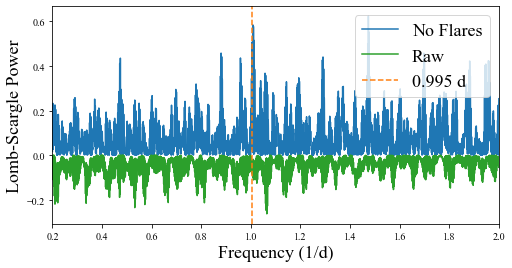

In [73]:
fig = plt.figure(figsize=(8.0,4.0))

plt.plot(freqs,power_radio,color=colours[0],label='No Flares')
plt.plot(freqs,-power_raw,color=colours[2],label='Raw')

plt.axvline(2./tm.best_period,linestyle='--',color=colours[1],label='%.3f d' % (tm.best_period/2.))
# plt.yscale('log')
plt.xlim(freqs.min(),freqs.max())
plt.xlabel(r'Frequency (1/d)',fontsize=18)
plt.ylabel('Lomb-Scargle Power',fontsize=18)
plt.legend(fontsize=18)
plt.savefig('cr_dra_lomb_scargle.pdf',bbox_inches='tight')
plt.savefig('cr_dra_lomb_scargle.png',bbox_inches='tight')

In [74]:
ls_radio.false_alarm_probability(power_radio.max()) 

<Quantity 7.4092187e-05>

In [75]:
ls_raw.false_alarm_probability(power_raw.max()) 

<Quantity 0.31203856>

In [76]:
ls_window = LombScargle(t[~bad],np.ones_like(flux[~bad]),error[~bad],center_data=False,fit_mean=False)

In [77]:
power_window = ls_window.power(freqs)


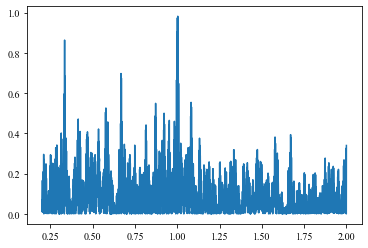

In [78]:
plt.plot(freqs,power_window)

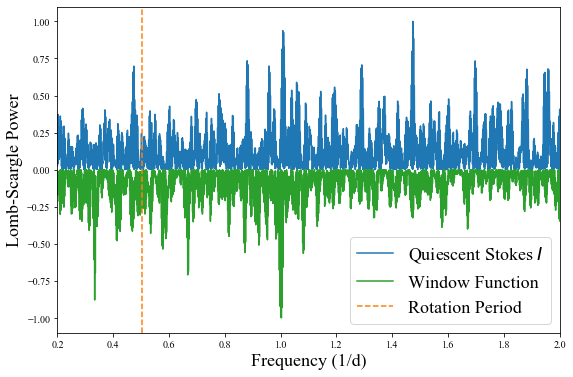

In [79]:
fig = plt.figure(figsize=(9.0,6.0))

plt.plot(freqs,power_radio/power_radio.max(),color=colours[0],label=r'Quiescent Stokes $I$')
plt.plot(freqs,-power_window/power_window.max(),color=colours[2],label='Window Function')

plt.axvline(1./(1.99),linestyle='--',color=colours[1],label='Rotation Period')
# plt.yscale('log')
plt.xlim(freqs.min(),freqs.max())
plt.xlabel(r'Frequency (1/d)',fontsize=18)
plt.ylabel('Lomb-Scargle Power',fontsize=18)
plt.legend(fontsize=18)
plt.savefig('cr_dra_lomb_scargle.pdf',bbox_inches='tight')
plt.savefig('cr_dra_lomb_scargle.png',bbox_inches='tight')

## How about higher order periodograms?

In [80]:
ls_raw = LombScargle(t,flux,error,nterms=5)
ls_radio = LombScargle(t[~bad],flux[~bad],error[~bad],nterms=5)
ls_window = LombScargle(t[~bad],np.ones_like(flux[~bad]),error[~bad],center_data=False,fit_mean=False,nterms=5)

In [81]:
%%time
periods = np.linspace(0.5,5,50000)
freqs = 1./periods[::-1]
power_radio = ls_radio.power(freqs)
power_raw = ls_raw.power(freqs)
power_window = ls_window.power(freqs)


CPU times: user 15.1 s, sys: 72 ms, total: 15.2 s
Wall time: 15.2 s


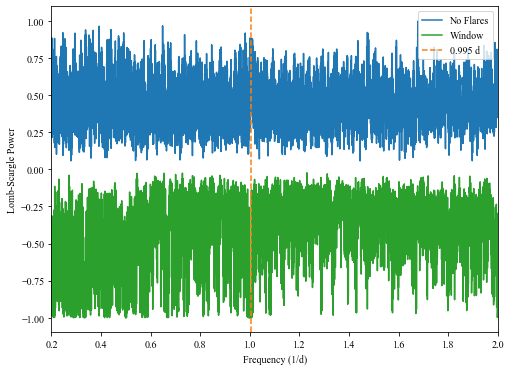

In [82]:
fig = plt.figure(figsize=(8.0,6.0))

plt.plot(freqs,power_radio/power_radio.max(),color=colours[0],label='No Flares')
plt.plot(freqs,-power_window/power_window.max(),color=colours[2],label='Window')

plt.axvline(2./tm.best_period,linestyle='--',color=colours[1],label='%.3f d' % (tm.best_period/2.))
# plt.yscale('log')
plt.xlim(freqs.min(),freqs.max())
plt.xlabel(r'Frequency (1/d)')
plt.ylabel('Lomb-Scargle Power')
plt.legend()
# plt.savefig('cr_dra_lomb_scargle.pdf',bbox_inches='tight')
# plt.savefig('cr_dra_lomb_scargle.png',bbox_inches='tight')

## Now try BLS

In [83]:
from astropy.timeseries import BoxLeastSquares

In [84]:
model = BoxLeastSquares(t[~bad] * u.day, flux[~bad], dy=0.01)

In [85]:
periods

array([0.5    , 0.50009, 0.50018, ..., 4.99982, 4.99991, 5.     ])

In [86]:
periodogram = model.power(periods, duration=0.25, objective="snr")

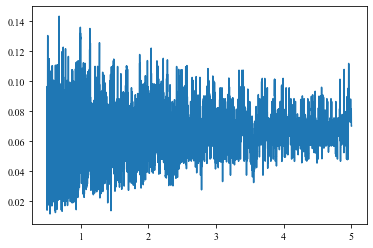

In [87]:
plt.plot(periodogram.period,periodogram.power)


# Now try Stella

In [88]:
import stella


In [89]:
cnn = stella.ConvNN(output_dir='.')


Can only use stella.ConvNN.predict().


In [90]:
MODEL_DIR = '/Users/benjaminpope/Downloads/run01/'
MODELS = [os.path.join(MODEL_DIR,i) for i in
          os.listdir(MODEL_DIR) if i.endswith('.h5')]


In [91]:
!ls /Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/stella

ls: /Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/stella: No such file or directory


In [92]:
cnn.predict(modelname=MODELS[0],
            times=lc.time,
            fluxes=lc.flux,
            errs=lc.flux_err)
single_pred = cnn.predictions[0]

100%|██████████| 1/1 [00:03<00:00,  3.31s/it]


(0.98, 1.03)

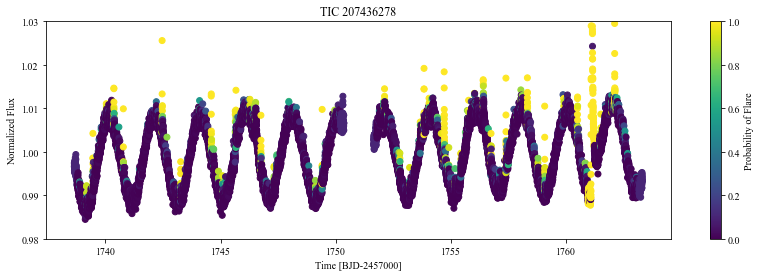

In [93]:
plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], cnn.predict_flux[0],
            c=cnn.predictions[0], vmin=0, vmax=1)
plt.colorbar(label='Probability of Flare')
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')
plt.title('TIC {}'.format(lc.targetid));
plt.ylim(0.98,1.03)

### Do all Sectors

In [94]:
%%time
rotation_models = []

for lcd in data_all:
    lc = lcd.get_lightcurve('PDCSAP_FLUX').remove_nans().normalize()
    tmodel = periodic.TrendedLombScargle(fit_period=True,Nterms=2)
    tmodel.quiet = True
    tmodel.optimizer.period_range = (1.9, 2.1)

    lc_test = lc.copy()
    outliers = [0]

    for j in tqdm(range(5),desc='Outlier clipping',postfix={'Outliers':np.sum(outliers)}):

        tm = tmodel.fit(lc_test.time, lc_test.flux, lc_test.flux_err)
        series = tm.predict(lc_test.time)
        lc2 = lc_test.copy()
        lc2.flux = lc_test.flux - series + np.nanmedian(series)
        cleaned, outliers = lc2.remove_outliers(return_mask=True,sigma=3.0)

        lc_test = lc_test[~outliers]
    final = tm.predict(lc.time)
    rotation_models.append(final)


Outlier clipping:   0%|          | 0/5 [00:00<?, ?it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.255
 - Using 5 steps per peak; omega_step = 0.0509
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Outlier clipping:  20%|██        | 1/5 [00:00<00:01,  2.16it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.255
 - Using 5 steps per peak; omega_step = 0.0509
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Outlier clipping:  40%|████      | 2/5 [00:00<00:01,  2.14it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.255
 - Using 5 steps per peak; omega_step = 0.0509
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Outlier clipping:  60%|██████    | 3/5 [00:01<00:00,  2.11it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.255
 - Using 5 steps per peak; omega_step = 0.0509
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Outlier clipping:  80%|████████  | 4/5 [00:01<00:00,  2.09it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.255
 - Using 5 steps per peak; omega_step = 0.0509
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Outlier clipping:   0%|          | 0/5 [00:00<?, ?it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.247
 - Using 5 steps per peak; omega_step = 0.0495
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Outlier clipping:  20%|██        | 1/5 [00:00<00:01,  2.04it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.247
 - Using 5 steps per peak; omega_step = 0.0495
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Outlier clipping:  40%|████      | 2/5 [00:00<00:01,  2.05it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.247
 - Using 5 steps per peak; omega_step = 0.0495
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Outlier clipping:  60%|██████    | 3/5 [00:01<00:00,  2.07it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.247
 - Using 5 steps per peak; omega_step = 0.0495
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Outlier clipping:  80%|████████  | 4/5 [00:01<00:00,  2.09it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.247
 - Using 5 steps per peak; omega_step = 0.0495
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Outlier clipping:   0%|          | 0/5 [00:00<?, ?it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.237
 - Using 5 steps per peak; omega_step = 0.0474
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Outlier clipping:  20%|██        | 1/5 [00:00<00:01,  2.14it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.237
 - Using 5 steps per peak; omega_step = 0.0474
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Outlier clipping:  40%|████      | 2/5 [00:00<00:01,  2.16it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.237
 - Using 5 steps per peak; omega_step = 0.0474
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Outlier clipping:  60%|██████    | 3/5 [00:01<00:00,  2.16it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.237
 - Using 5 steps per peak; omega_step = 0.0474
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Outlier clipping:  80%|████████  | 4/5 [00:01<00:00,  2.16it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.237
 - Using 5 steps per peak; omega_step = 0.0474
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Outlier clipping: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s, Outliers=0]


CPU times: user 28 s, sys: 243 ms, total: 28.3 s
Wall time: 7.11 s


(1925, 1975)

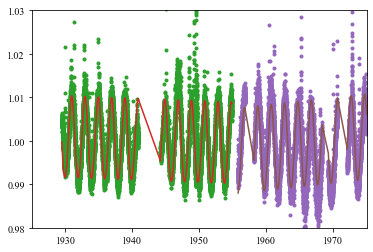

In [95]:
for j, lcd in enumerate(data_all):
    lc = lcd.get_lightcurve('PDCSAP_FLUX').remove_nans().normalize()
    pred = rotation_models[j]
    plt.plot(lc.time,lc.flux,'.')
    plt.plot(lc.time,pred,'-')
    
plt.ylim(0.98,1.03)
plt.xlim(1925,1975)

In [96]:
for lcd in data_all:
    print(lcd.sector,lcd.camera,lcd.ccd)

16 3 4
23 3 3
24 2 2


In [97]:
! ls /Users/benjaminpope/code/tessbkgd/data

cbv_15_3_4.fits            iotDra_Sector15_lc.fits.gz
cbv_16_3_4.fits            iotDra_Sector16_lc.fits.gz
cbv_22_3_3.fits            iotDra_Sector22_lc.fits.gz
cbv_23_3_3.fits            iotDra_Sector23_lc.fits.gz
cbv_23_3_4.fits            iotDra_Sector24_lc.fits.gz
cbv_24_2_2.fits


In [98]:
def apply_cbv(lc,plot=True):
    ddir = '../data/'
    cbvfile = 'cbv_%d_%d_%d.fits' % (lc.sector,lc.camera,lc.ccd)
    cbvdata = fits.open(ddir+cbvfile)
    cadencemask = match_cadences(cbvdata[1].data['CADENCENO'],lc.cadenceno)

    cbvs = np.zeros((7,len(cadencemask)))
    for j in range(7):
        cbvs[j,:] = cbvdata[1].data['VECTOR_%d' % (j+1)][cadencemask]

    design = lk.correctors.DesignMatrix(cbvs.T)
    design = design.append_constant()

    corrector = lk.correctors.RegressionCorrector(lc)
    corrected_lc = corrector.correct(design,sigma=3)

    if plot:
        corrector.diagnose()
    return corrected_lc

Outlier clipping:   0%|          | 0/5 [00:00<?, ?it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.255
 - Using 5 steps per peak; omega_step = 0.0509
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Outlier clipping:  20%|██        | 1/5 [00:00<00:01,  2.10it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.255
 - Using 5 steps per peak; omega_step = 0.0509
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Outlier clipping:  40%|████      | 2/5 [00:00<00:01,  2.10it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.255
 - Using 5 steps per peak; omega_step = 0.0509
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Outlier clipping:  60%|██████    | 3/5 [00:01<00:00,  2.08it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.255
 - Using 5 steps per peak; omega_step = 0.0509
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Outlier clipping:  80%|████████  | 4/5 [00:01<00:00,  2.10it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.255
 - Using 5 steps per peak; omega_step = 0.0509
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 995 steps


Outlier clipping:   0%|          | 0/5 [00:00<?, ?it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.247
 - Using 5 steps per peak; omega_step = 0.0495
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Outlier clipping:  20%|██        | 1/5 [00:00<00:02,  1.68it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.247
 - Using 5 steps per peak; omega_step = 0.0495
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Outlier clipping:  40%|████      | 2/5 [00:01<00:01,  1.67it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.247
 - Using 5 steps per peak; omega_step = 0.0495
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Outlier clipping:  60%|██████    | 3/5 [00:01<00:01,  1.77it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.247
 - Using 5 steps per peak; omega_step = 0.0495
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Outlier clipping:  80%|████████  | 4/5 [00:02<00:00,  1.84it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.247
 - Using 5 steps per peak; omega_step = 0.0495
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Outlier clipping:   0%|          | 0/5 [00:00<?, ?it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.237
 - Using 5 steps per peak; omega_step = 0.0474
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Outlier clipping:  20%|██        | 1/5 [00:00<00:01,  2.16it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.237
 - Using 5 steps per peak; omega_step = 0.0474
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Outlier clipping:  40%|████      | 2/5 [00:00<00:01,  2.15it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.237
 - Using 5 steps per peak; omega_step = 0.0474
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Outlier clipping:  60%|██████    | 3/5 [00:01<00:00,  2.17it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.237
 - Using 5 steps per peak; omega_step = 0.0474
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Outlier clipping:  80%|████████  | 4/5 [00:01<00:00,  2.16it/s, Outliers=0]

Finding optimal frequency:
 - Estimated peak width = 0.237
 - Using 5 steps per peak; omega_step = 0.0474
 - User-specified period range:  1.9 to 2.1
 - Computing periods at 8 steps
Zooming-in on 5 candidate peaks:
 - Computing periods at 1000 steps


Outlier clipping: 100%|██████████| 5/5 [00:02<00:00,  2.16it/s, Outliers=0]


Periods [1.990524996521418, 1.9866963974438065, 1.9916656101946633]
CPU times: user 31.5 s, sys: 340 ms, total: 31.9 s
Wall time: 8.21 s


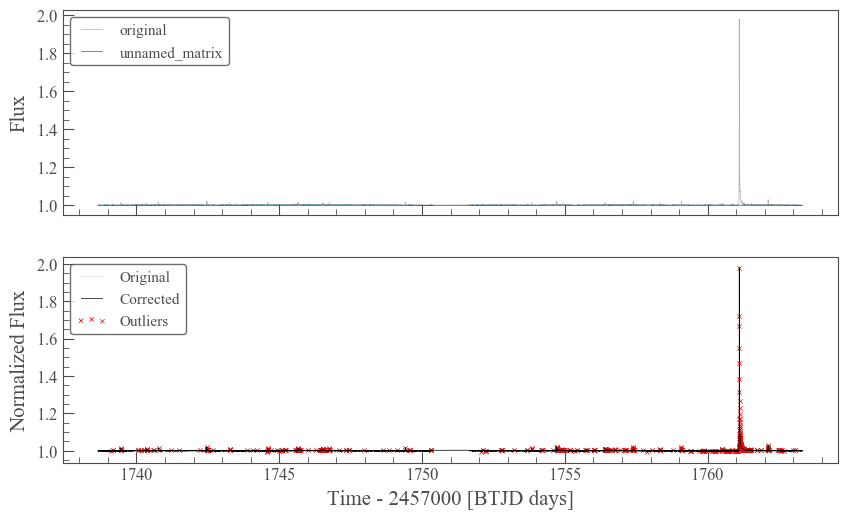

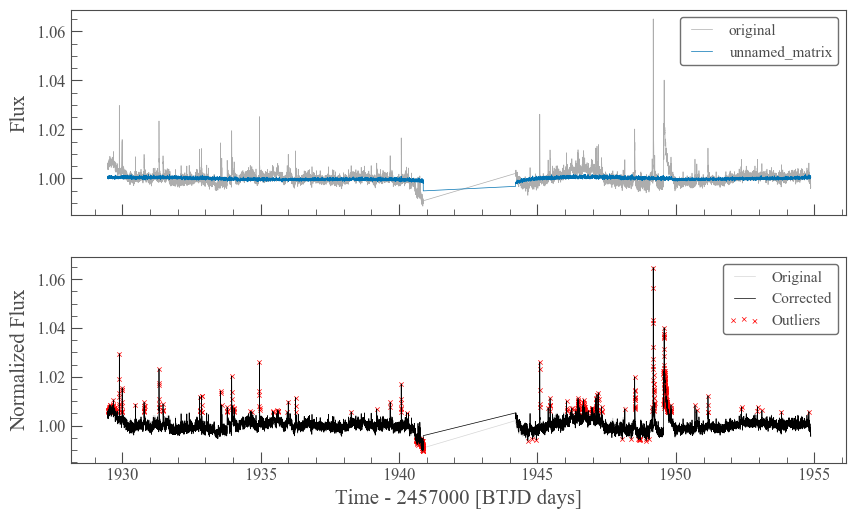

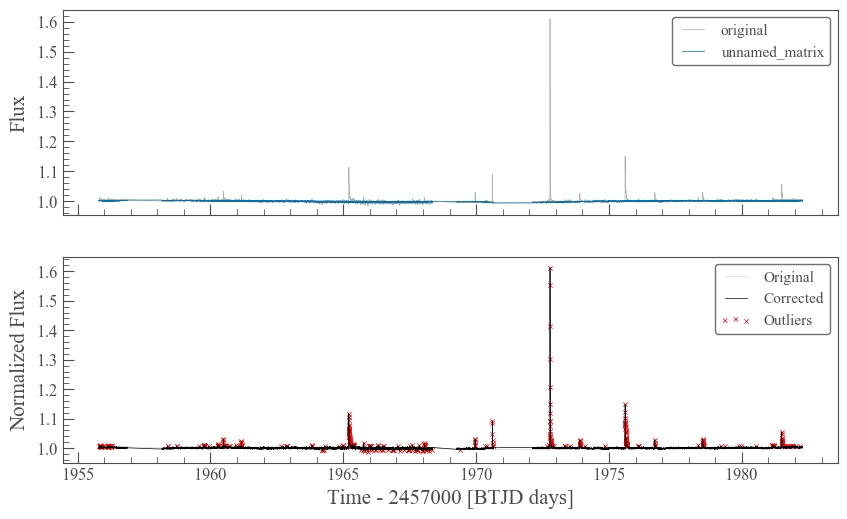

In [99]:
%%time
rotation_models = []
all_lcs = []
periods = []

for lcd in data_all:
    lc = lcd.get_lightcurve('PDCSAP_FLUX').remove_nans().normalize()
    tmodel = periodic.TrendedLombScargle(fit_period=True,Nterms=2)
    tmodel.quiet = True
    tmodel.optimizer.period_range = (1.9, 2.1)

    lc_test = lc.copy()
    outliers = [0]

    for j in tqdm(range(5),desc='Outlier clipping',postfix={'Outliers':np.sum(outliers)}):

        tm = tmodel.fit(lc_test.time, lc_test.flux, lc_test.flux_err)
        series = tm.predict(lc_test.time)
        lc2 = lc_test.copy()
        lc2.flux = lc_test.flux - series + np.nanmedian(series)
        cleaned, outliers = lc2.remove_outliers(return_mask=True,sigma=3.0)

        lc_test = lc_test[~outliers]
    final = tm.predict(lc.time)
    lc_out = lc.copy()
    lc_out.flux -= (final-1)
    lc_out = apply_cbv(lc_out,plot=True)
    lc_out.flux += (final-1)
    all_lcs.append(lc)

    rotation_models.append(final)

    periods.append(tm.best_period)
    
print('Periods',periods)

In [100]:
tm.best_period

1.9916656101946633

100%|██████████| 1/1 [00:03<00:00,  3.28s/it]


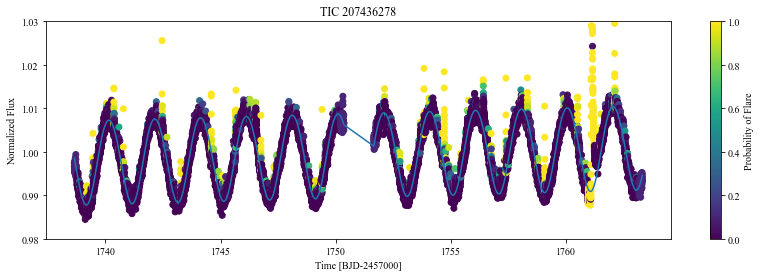

In [101]:
j = 0
lc = all_lcs[j]

cnn.predict(modelname=MODELS[0],
            times=lc.time,
            fluxes=lc.flux-rotation_models[j]+1,
            errs=lc.flux_err)
single_pred = cnn.predictions[0]

plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], lc.flux,
            c=cnn.predictions[0], vmin=0, vmax=1)
plt.plot(lc.time,rotation_models[j])
plt.colorbar(label='Probability of Flare')
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')
plt.title('TIC {}'.format(lc.targetid));
plt.ylim(0.98,1.03)
plt.savefig('cr_dra_flares_s%d.jpg' % lc.sector,bbox_inches='tight')

100%|██████████| 1/1 [00:03<00:00,  3.62s/it]


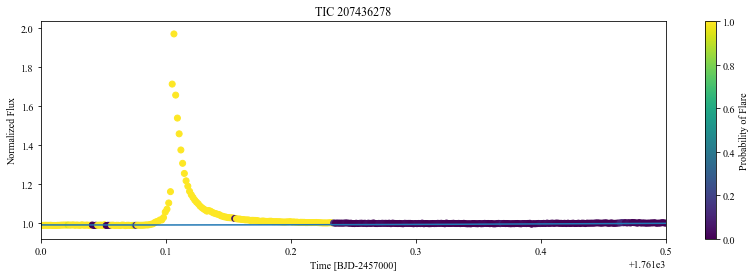

In [102]:
## zoom in on the biggest flare
j = 0
lc = all_lcs[j]

cnn.predict(modelname=MODELS[0],
            times=lc.time,
            fluxes=lc.flux-rotation_models[j]+1,
            errs=lc.flux_err)
single_pred = cnn.predictions[0]

plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], lc.flux,
            c=cnn.predictions[0], vmin=0, vmax=1)
plt.plot(lc.time,rotation_models[j])
plt.colorbar(label='Probability of Flare')
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')
plt.title('TIC {}'.format(lc.targetid));
# plt.ylim(0.98,1.03)
plt.xlim(1761,1761.5)
plt.savefig('cr_dra_flare_zoom_s%d.jpg' % lc.sector,bbox_inches='tight')

In [103]:
def find_gaps(timeseries,timeseries2):
    diff = timeseries[1:]-timeseries[:-1]
    dt = np.nanmedian(diff)
    gap = np.where((diff>(5*dt)) + (np.roll(diff,-1)>(5*dt)))
    gapped = timeseries2.copy()
    gapped[gap] = np.nan
    return gapped


gapped_rot = find_gaps(lc.time,rotation_models[1])

Finding & Fitting Flares: 100%|██████████| 1/1 [00:00<00:00,  1.89it/s]


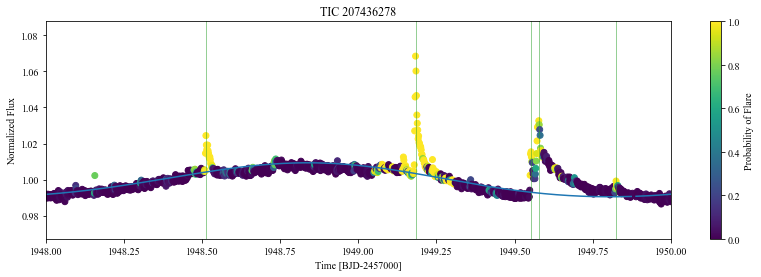

In [104]:
j = 1
lc = all_lcs[j]

cnn.predict(modelname=MODELS[0],
            times=lc.time,
            fluxes=lc.flux,
            errs=lc.flux_err)
single_pred = cnn.predictions[0]

plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], lc.flux,
            c=cnn.predictions[0], vmin=0, vmax=1)

ids = [0]
fitflares = stella.FitFlares(ids,[lc.time],
            [lc.flux-rotation_models[j]+1],
            [lc.flux_err],cnn.predictions)

fitflares.identify_flare_peaks()
targetid, tpeak, amp, dur, rise, fall, prob = (fitflares.flare_table[key] for key in fitflares.flare_table.keys())

# plt.plot(tpeak,amp,'.')
for k, peak in enumerate(tpeak):
#     plt.axvspan(peak,peak+dur[k],alpha=0.25)
    plt.axvline(peak,color=colours[2],lw=1,alpha=0.5)
    
gapped_rot = find_gaps(lc.time,rotation_models[j])
plt.plot(lc.time,gapped_rot)
plt.colorbar(label='Probability of Flare')
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')
plt.title('TIC {}'.format(lc.targetid));
# plt.ylim(0.98,1.03)
plt.xlim(1948,1950)
plt.savefig('cr_dra_flare_zoom_s%d.jpg' % lc.sector,bbox_inches='tight')

Finding & Fitting Flares: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


(1972.5, 1973)

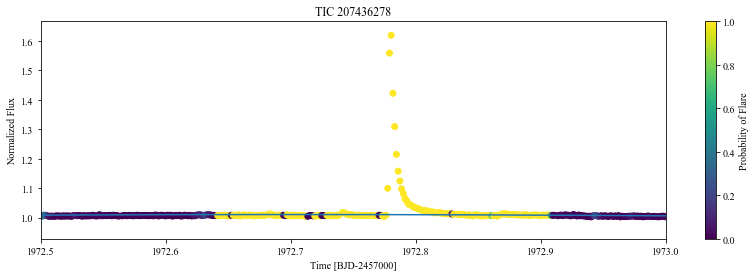

In [105]:
j = 2
lc = all_lcs[j]

cnn.predict(modelname=MODELS[0],
            times=lc.time,
            fluxes=lc.flux-rotation_models[j]+1,
            errs=lc.flux_err)
single_pred = cnn.predictions[0]

ids = [0]
fitflares = stella.FitFlares(ids,[lc.time],
            [lc.flux-rotation_models[j]+1],
            [lc.flux_err],cnn.predictions)

fitflares.identify_flare_peaks()
targetid, tpeak, amp, dur, rise, fall, prob = (fitflares.flare_table[key] for key in fitflares.flare_table.keys())

plt.figure(figsize=(14,4))
plt.scatter(cnn.predict_time[0], lc.flux,
            c=cnn.predictions[0], vmin=0, vmax=1)
plt.plot(lc.time,rotation_models[j])

# # plt.plot(tpeak,amp,'.')
# for j, peak in enumerate(tpeak):
# #     plt.axvspan(peak,peak+dur[j]/24.,alpha=0.25)
#     plt.axvline(peak,color=colours[2],lw=1,alpha=0.5)
    
plt.colorbar(label='Probability of Flare')
plt.xlabel('Time [BJD-2457000]')
plt.ylabel('Normalized Flux')
plt.title('TIC {}'.format(lc.targetid));
# plt.ylim(0.97,1.03)
plt.xlim(1972.5,1973)
# plt.savefig('cr_dra_flares_s%d.jpg' % lc.sector,bbox_inches='tight')

In [106]:
ids = [0,1,2]
times = [lc.time for lc in all_lcs]
fluxes = [lc.flux - rotation_models[j]+1 for j,lc in enumerate(all_lcs)]
flux_errs = [lc.flux_err for j,lc in enumerate(all_lcs)]

predictions = []
for j in range(3):
    cnn.predict(modelname=MODELS[0],
            times=times[j],
            fluxes=fluxes[j],
            errs=flux_errs[j])
    single_pred = cnn.predictions[0]
    predictions.append(single_pred)




100%|██████████| 1/1 [00:03<00:00,  3.27s/it]


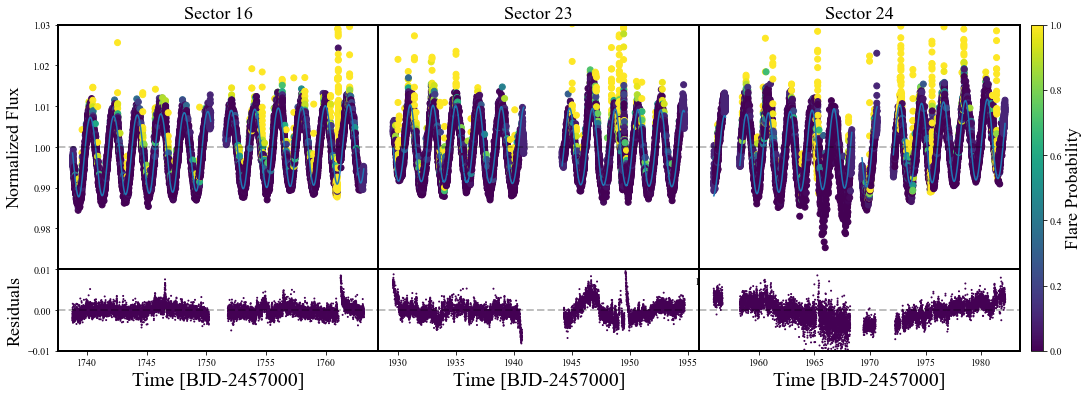

In [107]:
fig  = plt.figure(figsize=(16,6))
from matplotlib import gridspec
spec = gridspec.GridSpec(ncols=3, nrows=2,
                         height_ratios=[3, 1])


for j in range(3):
    (ax1,ax2) = (fig.add_subplot(spec[0,j]),fig.add_subplot(spec[1,j]))
    time, flux, flux_err, pred = times[j], all_lcs[j].flux, flux_errs[j], predictions[j]
    cc = ax1.scatter(time, flux,
            c=pred, vmin=0, vmax=1)
    gapped_rot = find_gaps(time,rotation_models[j])

    ax1.plot(time,gapped_rot)

    mask = pred>0.01
    ax2.scatter(time[~mask], (flux-rotation_models[j])[~mask],
            c=pred[~mask], vmin=0, vmax=1,s=1)

    # # plt.plot(tpeak,amp,'.')
    # for j, peak in enumerate(tpeak):
    # #     plt.axvspan(peak,peak+dur[j]/24.,alpha=0.25)
    #     plt.axvline(peak,color=colours[2],lw=1,alpha=0.5)

    #     plt.colorbar(label='Probability of Flare')
    
    if j ==0:
        ax1.set_ylabel('Normalized Flux',fontsize = 18,labelpad=10)
        ax2.set_ylabel('Residuals',fontsize = 18)
        ax1.set_yticks([0.98,0.99,1.00,1.01,1.02,1.03])
        ax2.set_yticks([-0.02,-0.01,0,0.01,0.02])
    else:
        ax1.set_yticks([])
        ax2.set_yticks([])

    ax1.set_title('Sector {}'.format(all_lcs[j].sector),fontsize=18);
    ax1.set_ylim(0.97,1.03)
    
    ax2.set_ylim(-0.01,0.01)
    ax2.set_xlabel('Time [BJD-2457000]',fontsize = 20)
    ax1.axhline(1,color='k',linestyle='--',alpha=0.25,lw=2)

    ax2.axhline(0,color='k',linestyle='--',alpha=0.25,lw=2)
    for axis in ['top','bottom','left','right']:
        ax1.spines[axis].set_linewidth(2)
        ax2.spines[axis].set_linewidth(2)

    
fig.subplots_adjust(right=0.96)
cbar_ax = fig.add_axes([0.97, 0.125, 0.01, 0.755])
fig.colorbar(cc, cax=cbar_ax).set_label(label='Flare Probability',size=18)


ax2.set_xticks([1960,1965,1970,1975,1980])
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('cr_dra_flares_all.jpg',bbox_inches='tight')
plt.savefig('cr_dra_flares_all.pdf',bbox_inches='tight')

In [108]:
fitflares = stella.FitFlares(ids,times,fluxes,flux_errs,predictions)
fitflares.identify_flare_peaks()

Finding & Fitting Flares: 100%|██████████| 3/3 [00:00<00:00,  3.18it/s]


In [109]:
fitflares.flare_table.keys()

['Target_ID', 'tpeak', 'amp', 'dur_min', 'rise', 'fall', 'prob']

In [110]:
targetid, tpeak, amp, dur, rise, fall, prob = (fitflares.flare_table[key] for key in fitflares.flare_table.keys())

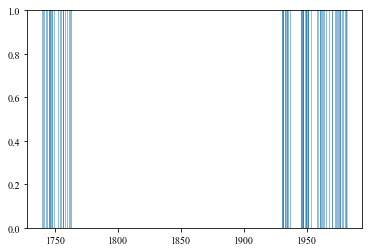

In [111]:
# plt.plot(tpeak,amp,'.')
for j, peak in enumerate(tpeak):
    plt.axvline(peak,alpha=prob[j]*0.5,lw=1)

In [112]:
dt = np.nanmedian(times[0][1:]-times[0][:-1])
total_time = len(times[0])*dt + len(times[1])*dt + len(times[2])*dt
print('Total time %.2f d' % total_time)
print('%.3f flares per day' %( len(tpeak)/total_time))

Total time 66.84 d
1.182 flares per day
